**DINAMICA DI UN POLIMERO SEMI-FLESSIBILE**

INTRODUZIONE:


Quando si parla di **dinamica di un filamento di DNA sintetico** ci si riferisce al modo in cui questo filamento si comporta e interagisce con il suo ambiente. Ci riferiamo principalmente a due aspetti principali:


*   **Struttura e Conformazione**: il DNA sintetico, come quello naturale, può assumere diverse conformazioni e strutture a seconda delle condizioni ambientali e delle interazioni molecolari.
*   **Interazioni molecolari**: il DNA sintetico può interagire con altre molecole biologiche e con l'ambiente circostante. Queste interazioni sono cruciali per la regolazione dell'espressione genica e per altri processi biologici in cui il DNA è coinvolto.

Le varie strutture che il DNA può assumere sono essenziali per le sue funzioni biologiche. Queste strutture non solo influenzano la stabilità e l'accessibilità del DNA, ma sono anche cruciali per l'interazione con altre molecole biologiche, contribuendo a processi come la replicazione, la trascrizione e la riparazione del DNA. La comprensione di queste dinamiche è fondamentale in molti campi della ricerca biologica e medica.

Vogliamo qui studiare le diverse strutture che un filamento può assumere.

MODULO ESTERNO DELLE FUNZIONI

In [5]:
%%writefile wlc_module.py
import numpy as np
from scipy.stats import entropy  # Per la divergenza KL

# Funzione per generare theta da una distribuzione gaussiana
def generate_theta(delta_theta, size=1):
    """Genera angoli theta da una distribuzione normale con media 0 e varianza delta_theta^2."""
    return np.random.normal(0, delta_theta, size)

# Funzione per generare phi uniformemente distribuito in [0, 2*pi]
def generate_phi(size=1):
    """Genera angoli phi da una distribuzione uniforme tra 0 e 2*pi."""
    return np.random.uniform(0, 2 * np.pi, size)

# Funzione per ruotare un vettore di un angolo theta attorno ad un asse k
def rotate_vector(v, k, theta):
    """Ruota un vettore v di un angolo theta attorno all'asse k."""
    k = k / np.linalg.norm(k)  # Normalizza l'asse di rotazione
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    v_rot = v * cos_theta + np.cross(k, v) * sin_theta + k * np.dot(k, v) * (1 - cos_theta)
    return v_rot

# Funzione per generare la Worm-Like Chain
def generate_wlc(N, b, delta_theta):
    """Genera una Worm-Like Chain di N segmenti, ciascuno di lunghezza b, con variazioni angolari standard delta_theta."""
    positions = np.zeros((N+1, 3))  # (x, y, z)

    # Inizializzo il primo vettore di direzione in una direzione casuale (coordinate sferiche)
    theta = generate_theta(delta_theta, 1)[0]
    phi = generate_phi(1)[0]
    direction = np.array([np.sin(theta) * np.cos(phi),
                          np.sin(theta) * np.sin(phi),
                          np.cos(theta)])

    for i in range(1, N+1):
        # Genera il nuovo angolo theta relativo e un phi casuale
        theta_rel = generate_theta(delta_theta, 1)[0]
        phi_rel = generate_phi(1)[0]

        # Asse di rotazione: un vettore ortogonale alla direzione corrente
        k = np.random.randn(3)  # Genero un asse casuale
        k -= k.dot(direction) * direction / np.linalg.norm(direction)**2  # Rendo l'asse ortogonale alla direzione
        k = k / np.linalg.norm(k)  # Normalizzo

        # Ruoto la direzione corrente per ottenere il nuovo segmento
        direction = rotate_vector(direction, k, theta_rel)

        # Aggiorna la posizione
        positions[i] = positions[i-1] + b * direction

    return positions

# Funzione per calcolare la distanza end-to-end
def end_to_end_distance(positions):
    """Calcola la distanza end-to-end tra la prima e l'ultima posizione della WLC."""
    return np.linalg.norm(positions[-1] - positions[0])

# Funzione per eseguire le simulazioni per differenti valori di N
def run_simulation(N_values, L, lp, num_simulations):
    """Esegue la simulazione della Worm-Like Chain per una serie di valori di N, con parametri dati."""
    distances = {}  # Per salvare le distanze end-to-end per ciascun N

    for N in N_values:
        b = L / N  # Calcola b in modo che la lunghezza totale L sia fissata a 1
        delta_theta = np.sqrt(2 * b / lp)  # Calcola delta_theta con l_p normalizzata rispetto a L

        distances[N] = []
        for _ in range(num_simulations):
            positions = generate_wlc(N, b, delta_theta)
            r = end_to_end_distance(positions)
            distances[N].append(r / L)  # Normalizziamo r rispetto alla lunghezza totale L = 1

    return distances

# Funzione per eseguire le simulazioni su più lunghezze di persistenza l_p
def run_simulation_lp(N, L, lp_values, num_simulations):
    b = L / N  # Lunghezza di ogni segmento con L = 1
    distances1 = {}
    for lp in lp_values:
        delta_theta = np.sqrt(2 * b / lp)  # Calcoliamo delta_theta con l_p normalizzato
        distances1[lp] = []
        for _ in range(num_simulations):
            positions = generate_wlc(N, b, delta_theta)
            r = end_to_end_distance(positions)
            distances1[lp].append(r / L)  # Normalizziamo rispetto a L = 1
    return distances1

# Funzione per eseguire simulazioni specifiche per una lunghezza di persistenza l_p
def run_simulation_specific_lp(N, L, lp, num_simulations):
    b = L / N  # Lunghezza di ogni segmento con L = 1
    delta_theta = np.sqrt(2 * b / lp)
    distances2 = []
    for _ in range(num_simulations):
        positions = generate_wlc(N, b, delta_theta)
        r = end_to_end_distance(positions)
        distances2.append(r / L)  # Normalizziamo rispetto a L = 1
    return distances2

# Funzione per la distribuzione analitica approssimata Q(r, t)
def Q_r(r, t):
    alpha = 3 * t / 4
    if alpha <= 0:
        return np.zeros_like(r)
    C = 1 / ((np.pi ** (3 / 2)) * np.exp(-alpha) * alpha ** (-3 / 2) *
             (1 + 3 / alpha + (15 / 4) / alpha ** 2))
    prefactor = (4 * np.pi * C)
    term1 = r ** 2 / (1 - r ** 2) ** (9 / 2)
    term2 = np.exp(-alpha / (1 - r ** 2))
    return prefactor * term1 * term2

# Funzione per eseguire la simulazione
def run_simulationQ(N, b, lp_values, num_simulations, L=1.0):
    distances3 = {}
    for lp in lp_values:
        delta_theta = np.sqrt(2 * b / lp)
        distances3[lp] = []
        for _ in range(num_simulations):
            positions = generate_wlc(N, b, delta_theta)
            r = end_to_end_distance(positions)
            distances3[lp].append(r / L)
    return distances3

# Funzione per calcolare la divergenza KL
def calculate_kl_divergence(sim_hist, Q_values):
    return entropy(sim_hist + 1e-10, Q_values + 1e-10)

# Funzione per calcolare l'errore quadratico medio (EQM)
def calculate_eqm(sim_hist, Q_values):
    return np.mean((sim_hist - Q_values) ** 2)

# Funzione di analisi per calcolare divergenza KL ed EQM per diverse lunghezze di persistenza lp
def run_analysis(distances, lp_values, N, b):
    kl_distances = []
    eqm_distances = []

    for lp in lp_values:
        delta_theta = np.sqrt(2 * b / lp)

        # Istogramma della distribuzione simulata
        sim_hist, bin_edges = np.histogram(distances[lp], bins=30, range=(0, 1), density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # Parametro teorico t = L / l_0 con l_0 = (2/3) * l_p
        l0 = (2 / 3) * lp
        L_total = N * b
        t = L_total / l0

        # Valori teorici Q(r)
        Q_values = Q_r(bin_centers, t)
        Q_values /= np.trapz(Q_values, bin_centers)

        # Calcolo delle metriche di distanza
        kl_divergence = calculate_kl_divergence(sim_hist, Q_values)
        kl_distances.append(kl_divergence)

        eqm = calculate_eqm(sim_hist, Q_values)
        eqm_distances.append(eqm)

    return kl_distances, eqm_distances

Overwriting wlc_module.py


UN PO' DI CHIAREZZA SUL CODICE

Facciamo un po' di chiarezza su alcune righe del **codice** qui, in modo da non appesantire il codice e renderlo più leggibile.


* **Δ(θ)** rappresenta una misura della flessibilità della catena e viene utilizzato per determinare la distribuzione degli angoli di direzione nella generazione della catena.
* **Riga 17**: in questa linea di codice normalizziamo il vettore $k$, l'asse attorno al quale ruotiamo il vettore $v$; cioè trasformiamo $k$ in un vettore unitario; altrimenti la formula di rotazione di Rodrigues verrebbe influenzata dalla lunghezza del vettore $k$.
* **Riga 20**: Questa è la **formula di rotazione di Rodrigues**, che permette di ruotare un vettore $v$ di un angolo $θ$ attorno a un asse $k$. Vediamo i vari termini:
    1. $v*cos(θ)$: Proiezione di $v$ nella direzione originale (prodotto scalare).
    2. $np.cross(k, v)$ $*$ $sin(θ)$: Vettore perpendicolare a $v$ e $k$, scalato da $sin(θ)$. Serve a far ruotare $v$ in un piano ortogonale a $k$.
    1. $k * np.dot(k, v) * (1 - cos(θ))$
* **Riga 54**: Calcola la distanza tra il primo e l'ultimo punto sottraendo le coordinate dell'ultimo punto alle coordinate del primo punto; poi calcola la **norma euclidea** del vettore che unisce il primo e l'ultimo punto della catena.









SIMULAZIONE DELLA WORM-LIKE-CHAIN

Una **worm-like-chain** (**WLC**) è un modello che descrive un polimero semi-flessibile, diviso in segmenti successivi la cui direzione dipende da due parametri, **gli angoli polari** $(\phi, θ)$, che poi vedremo come vengono scelti nel codice; $θ$ determina quanto ogni segmento si discosta **verticalmente** dall’asse $z$ (quindi l'angolo di inclinazione rispetto alla "verticale"), $ϕ$ determina l’orientamento del vettore di direzione in un piano **orizzontale**.

La WLC è caratterizzata da una **lunghezza di persistenza** $l_p$, cioè la lunghezza su cui la direzione della catena si mantiene correlata (rigida). Qui simuliamo una WLC, che sarà il punto di partenza per le considerazioni successive.

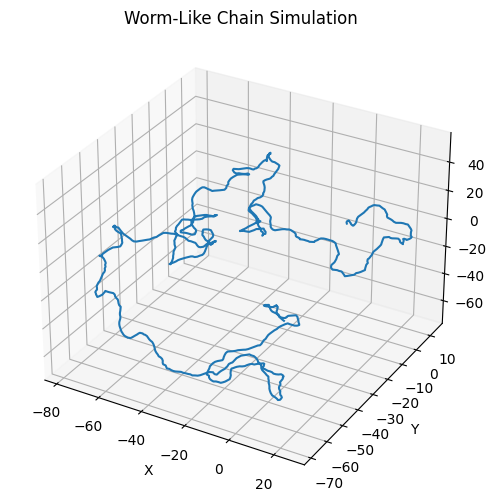

In [7]:
import wlc_module as wlc
import matplotlib.pyplot as plt
import numpy as np

# Parametri del modello WLC
N = 1000  # Numero di segmenti
b = 1.0   # Lunghezza di ogni segmento
lp = 10.0 # Lunghezza di persistenza
delta_theta = np.sqrt(2 * b / lp)

# Genera la Worm-Like Chain
positions = wlc.generate_wlc(N, b, delta_theta)

# Plot della WLC nello spazio 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], lw=1.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Worm-Like Chain Simulation')
plt.show()

PROPRIETÀ FISICHE DELLA WLC

Ora studiamo le **proprietà fisiche della catena**: data una $l_P$, lunghezza di persistenza, voglio verificare che $P(r)$, la **distribuzione della end-to-end distance**, **è indipendente dal numero di pezzi rigidi $N$** in cui si divide la WLC. Dalla teoria sappiamo che per grandi $N$, la distanza end-to-end segue una distribuzione gaussiana centrata sulla media della distanza quadratica end-to-end $\langle r^2 \rangle$, che è proporzionale a: $$\langle r^2 \rangle∼2⋅l_p⋅L$$
con $L$=$N$⋅$b$; dove $L$ è la lunghezza totale della catena e $l_P$ è la lunghezza di persistenza.

Questo significa che, se il numero di segmenti $N$ è sufficientemente grande, la distribuzione di $r$ non dipende più da $N$, ma solo da $l_P$.

Nel plot risultante, dovremmo osservare che le curve per i vari valori di $N$ tendono a sovrapporsi, dimostrando che la distribuzione della distanza end-to-end è effettivamente indipendente da $N$.

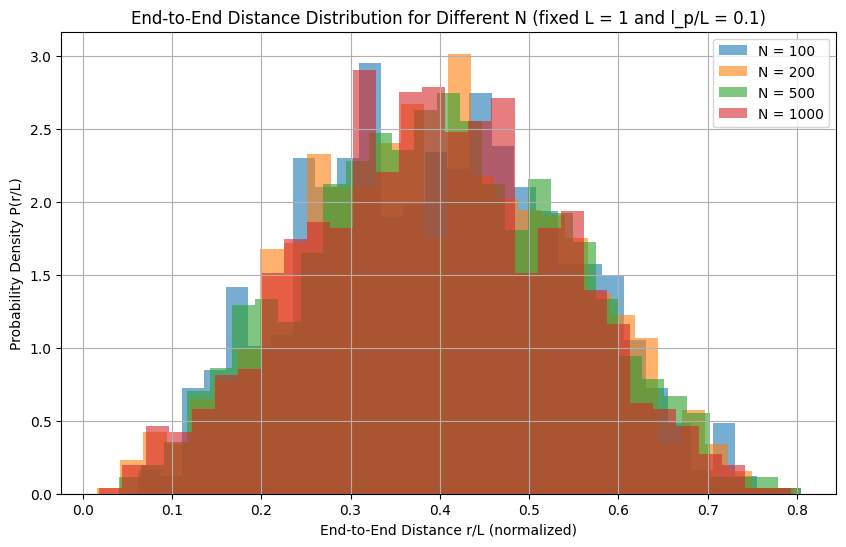

In [8]:
import importlib
import wlc_module
importlib.reload(wlc_module)
import wlc_module as wlc
import matplotlib.pyplot as plt
import numpy as np

# Parametri del modello
L = 1.0    # Lunghezza totale della catena fissata a 1
lp = 0.1   # Lunghezza di persistenza normalizzata rispetto a L
num_simulations = 1000  # Numero di simulazioni per ogni N
N_values = [100, 200, 500, 1000]  # Differenti valori di N

# Esegui le simulazioni
distances = wlc.run_simulation(N_values, L, lp, num_simulations)

# Plot delle distribuzioni della distanza end-to-end normalizzata
plt.figure(figsize=(10, 6))
for N in N_values:
    plt.hist(distances[N], bins=30, density=True, alpha=0.6, label=f'N = {N}')
plt.xlabel('End-to-End Distance r/L (normalized)')
plt.ylabel('Probability Density P(r/L)')
plt.title(f'End-to-End Distance Distribution for Different N (fixed L = 1 and l_p/L = {lp})')
plt.legend()
plt.grid(True)
plt.show()

Continuando a studiare le proprietà fisiche della catena, vediamo ora cosa succede se **fisso un valore di $N$** e faccio variare la lunghezza di persistenza $l_p$.
Dalla teoria ci aspettiamo che:


*   Per valori di $l_p$ **più grandi**, la **catena** diventa più **rigida**, e la distribuzione della distanza end-to-end si concentrerà su valori più vicini a 1 (cioè $r/L$ sarà vicino a 1, perché la catena è quasi rettilinea).
*   Per valori di $l_p$ **più piccoli**, la **catena** diventa più **flessibile**, e la distribuzione della distanza end-to-end sarà più ampia, con una media più piccola, poiché la catena si piega e si aggroviglia di più.



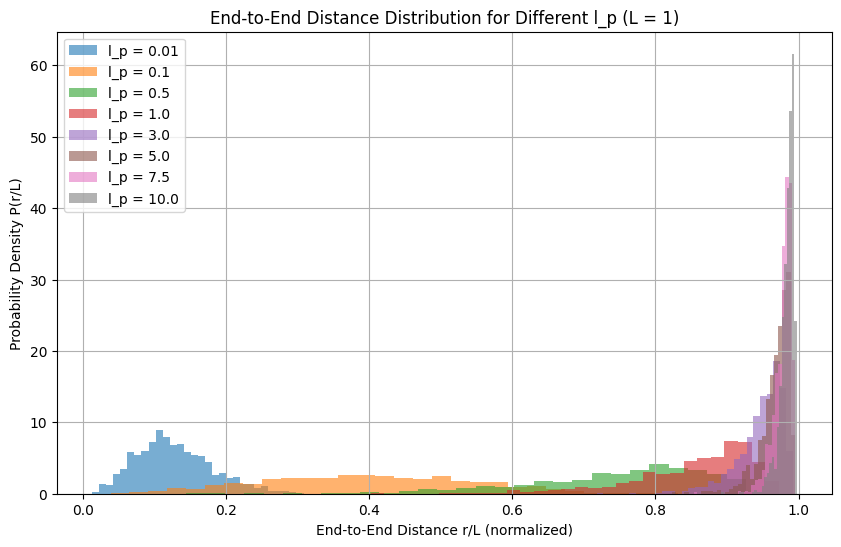

In [9]:
import importlib
import wlc_module
importlib.reload(wlc_module)
import wlc_module as wlc
import matplotlib.pyplot as plt
import numpy as np

# Parametri del modello
L = 1.0  # Lunghezza totale fissata a 1
N = 500  # Numero di segmenti fissato
lp_values = [0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 7.5, 10.0]  # Differenti lunghezze di persistenza normalizzate
num_simulations = 1000  # Numero di simulazioni per ogni l_p

# Eseguiamo la simulazione per i vari valori di l_p
distances1 = wlc.run_simulation_lp(N, L, lp_values, num_simulations)

# Plot delle distribuzioni della distanza end-to-end normalizzata
plt.figure(figsize=(10, 6))
for lp in lp_values:
    plt.hist(distances1[lp], bins=30, density=True, alpha=0.6, label=f'l_p = {lp}')
plt.xlabel('End-to-End Distance r/L (normalized)')
plt.ylabel('Probability Density P(r/L)')
plt.title(f'End-to-End Distance Distribution for Different l_p (L = 1)')
plt.legend()
plt.grid(True)
plt.show()

Sempre dalla teoria sappiamo che (evidenziamo due casi particolari già visti nel plot precedente):


*   Per $l_p$ piccolo $P(r)$ tende ad una **Gaussian Chain**
*   Per $l_p$ grande $P(r)$ tende ad una **catena rigida**




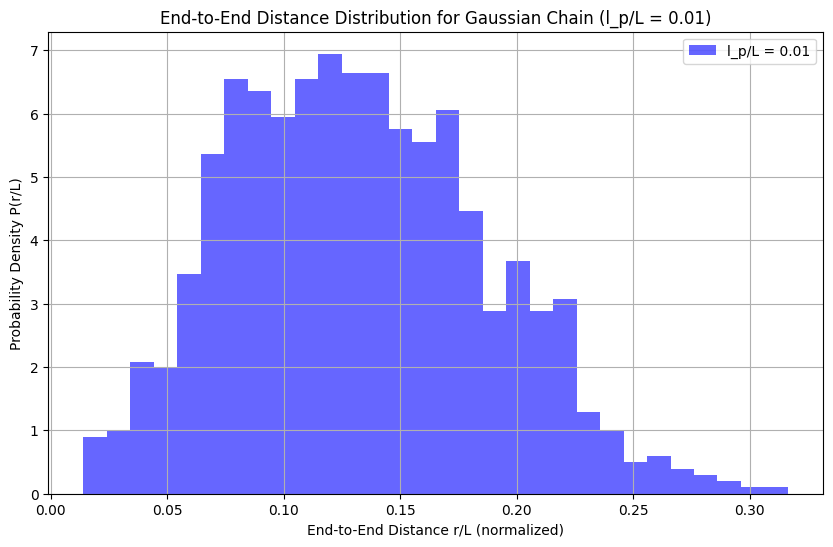

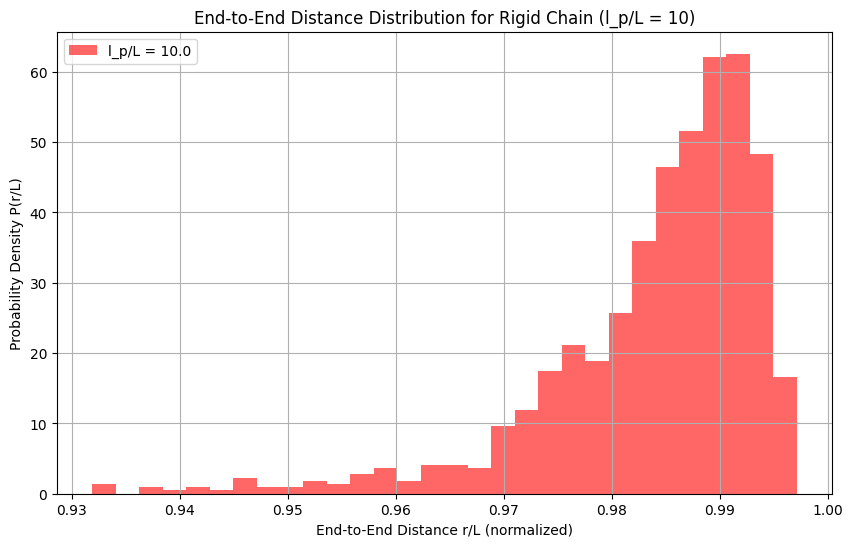

In [10]:
import importlib
import wlc_module
importlib.reload(wlc_module)
import wlc_module as wlc
import matplotlib.pyplot as plt
import numpy as np

# Parametri del modello WLC
L = 1.0  # Lunghezza totale fissata a 1
N = 500  # Numero di segmenti fissato
num_simulations = 1000  # Numero di simulazioni per ogni l_p

# Simulazione per l_p/L = 0.01 (Catena gaussiana)
lp_gaussian = 0.01
distances2_gaussian = wlc.run_simulation_specific_lp(N, L, lp_gaussian, num_simulations)

# Simulazione per l_p/L = 10 (Catena rigida)
lp_rigid = 10.0
distances2_rigid = wlc.run_simulation_specific_lp(N, L, lp_rigid, num_simulations)

# Plot per la catena gaussiana (l_p/L = 0.01)
plt.figure(figsize=(10, 6))
plt.hist(distances2_gaussian, bins=30, density=True, alpha=0.6, color='blue', label=f'l_p/L = {lp_gaussian}')
plt.xlabel('End-to-End Distance r/L (normalized)')
plt.ylabel('Probability Density P(r/L)')
plt.title('End-to-End Distance Distribution for Gaussian Chain (l_p/L = 0.01)')
plt.legend()
plt.grid(True)
plt.show()

# Plot per la catena rigida (l_p/L = 10)
plt.figure(figsize=(10, 6))
plt.hist(distances2_rigid, bins=30, density=True, alpha=0.6, color='red', label=f'l_p/L = {lp_rigid}')
plt.xlabel('End-to-End Distance r/L (normalized)')
plt.ylabel('Probability Density P(r/L)')
plt.title('End-to-End Distance Distribution for Rigid Chain (l_p/L = 10)')
plt.legend()
plt.grid(True)
plt.show()

CONFRONTO CON IL MODELLO ANALITICO

Prendiamo ora un **modello analitico** e confrontiamolo con il nostro modello da un punto di vista **qualitativo**.

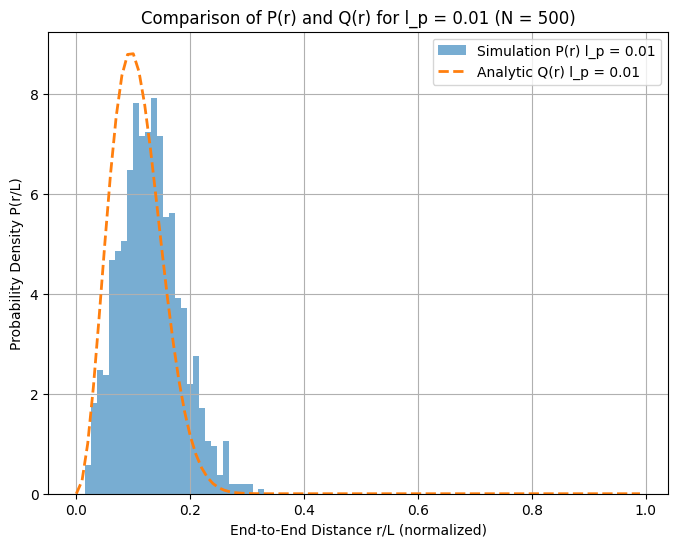

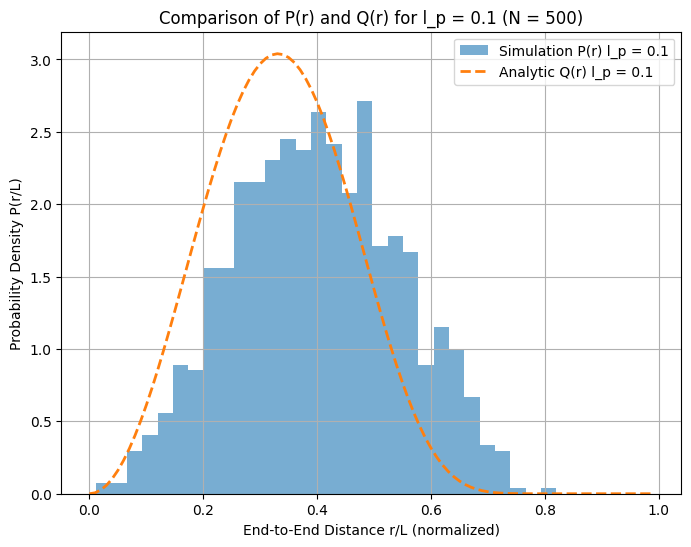

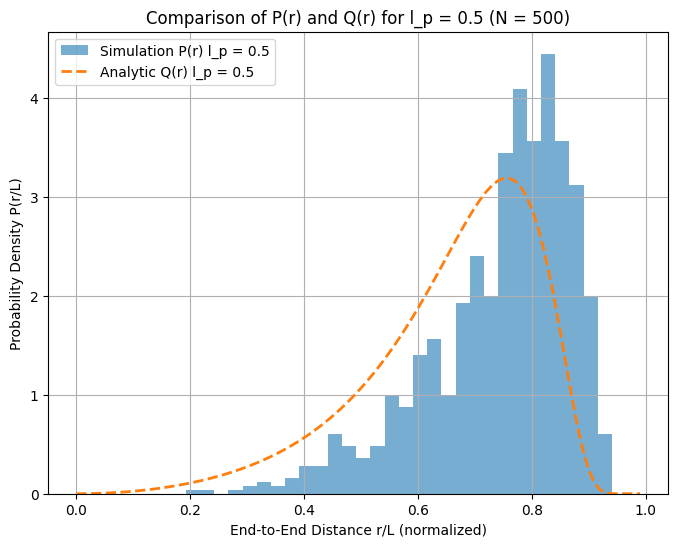

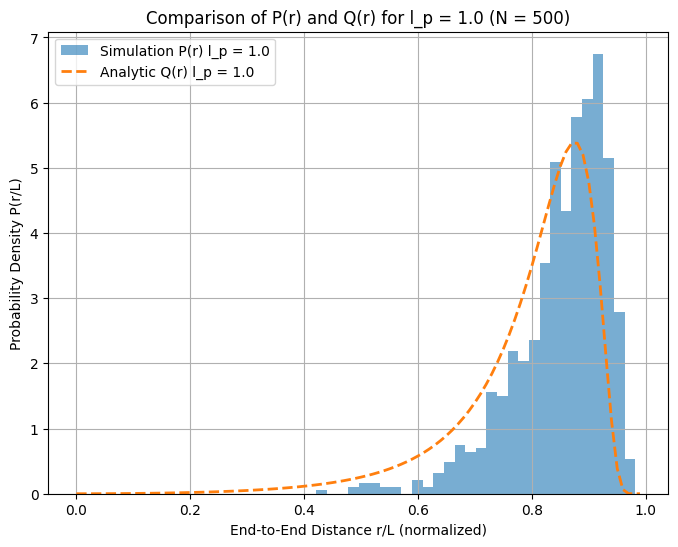

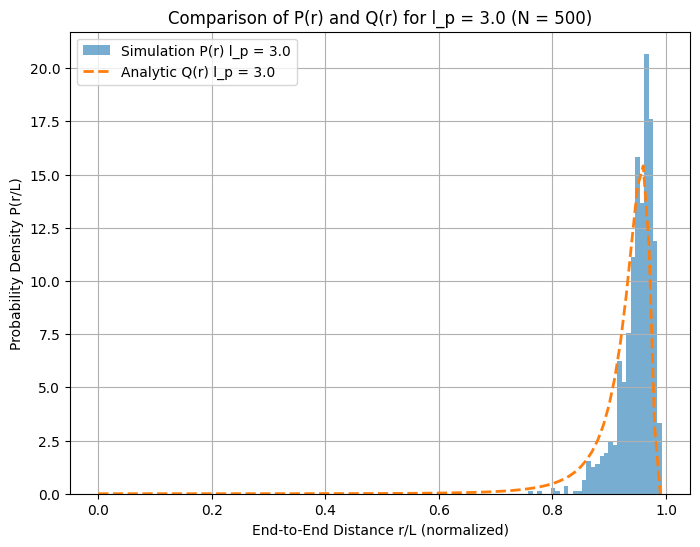

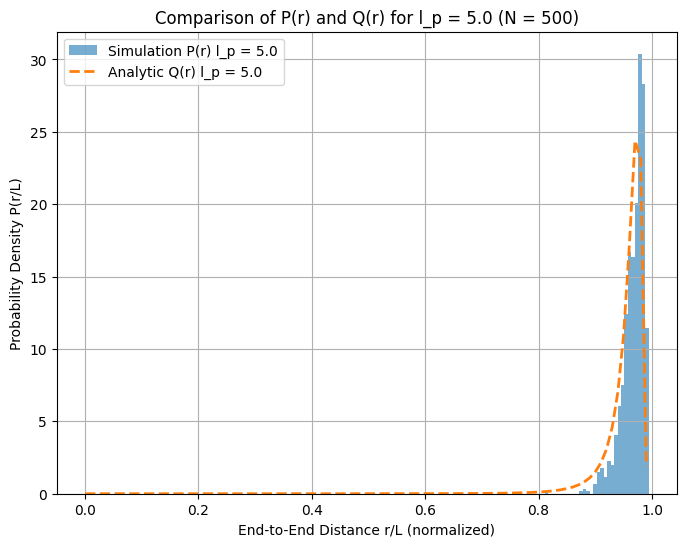

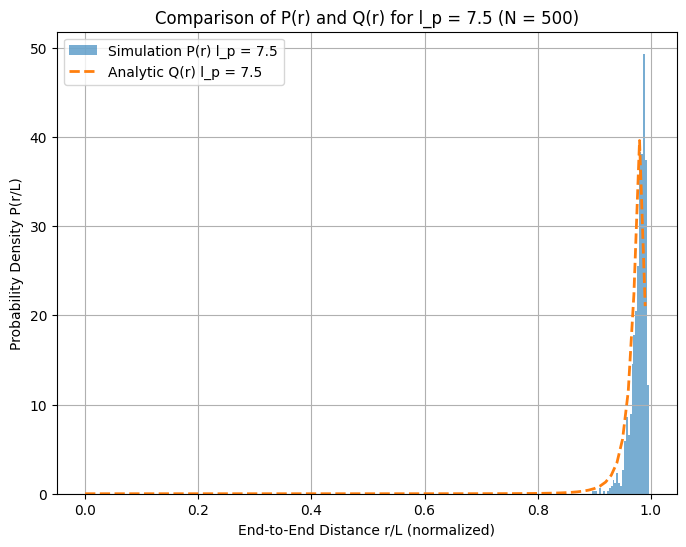

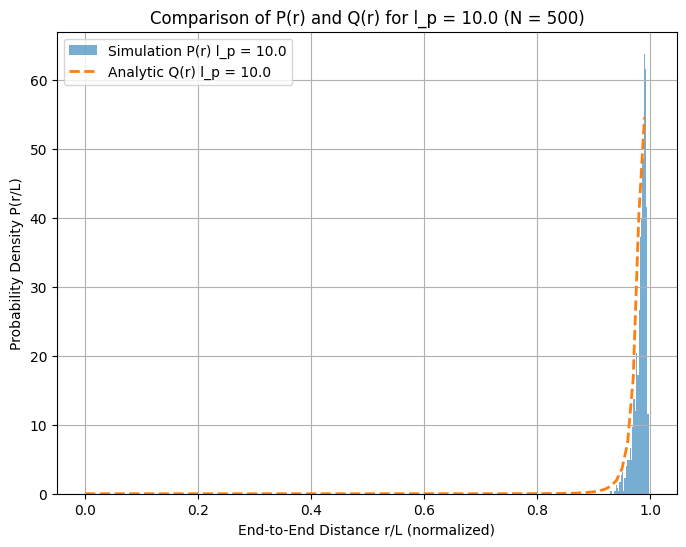

In [14]:
import importlib
import wlc_module
importlib.reload(wlc_module)
import wlc_module as wlc
import matplotlib.pyplot as plt
import numpy as np

# Parametri del modello
L = 1.0
N = 500
b = L / N
lp_values = [0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 7.5, 10.0]
num_simulations = 1000

# Esegui la simulazione
distances3 = wlc.run_simulationQ(N, b, lp_values, num_simulations, L)

# Plot delle distribuzioni simulata e analitica
r_values = np.linspace(0, 0.99, 100)

for lp in lp_values:
    plt.figure(figsize=(8, 6))
    l0 = (2 / 3) * lp
    L_total = N * b
    t = L_total / l0

    Q_values = wlc.Q_r(r_values, t)
    Q_values /= np.trapz(Q_values, r_values)

    plt.hist(distances3[lp], bins=30, density=True, alpha=0.6, label=f'Simulation P(r) l_p = {lp}')
    plt.plot(r_values, Q_values, '--', lw=2, label=f'Analytic Q(r) l_p = {lp}')
    plt.xlabel('End-to-End Distance r/L (normalized)')
    plt.ylabel('Probability Density P(r/L)')
    plt.title(f'Comparison of P(r) and Q(r) for l_p = {lp} (N = {N})')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.show()

Ora confrontiamo il modello analitico con il nostro modello da un punto di vista **quantitativo**: usiamo come parametri l'**errore quadratico medio** (**EQM**) e la **divergenza di Kullback-leiber** (**KL**).


* Errore quadratico medio (EQM): $$\text{EQM} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
dove $y_i$ è il valore vero; $\hat{y}_i$ è il valore predetto; $n$ è il numero totale di dati.


* Divergenza di Kullback-leiber (KL): $$D_{KL}(P \parallel Q) = \sum_i P(i) \log \left( \frac{P(i)}{Q(i)} \right)$$





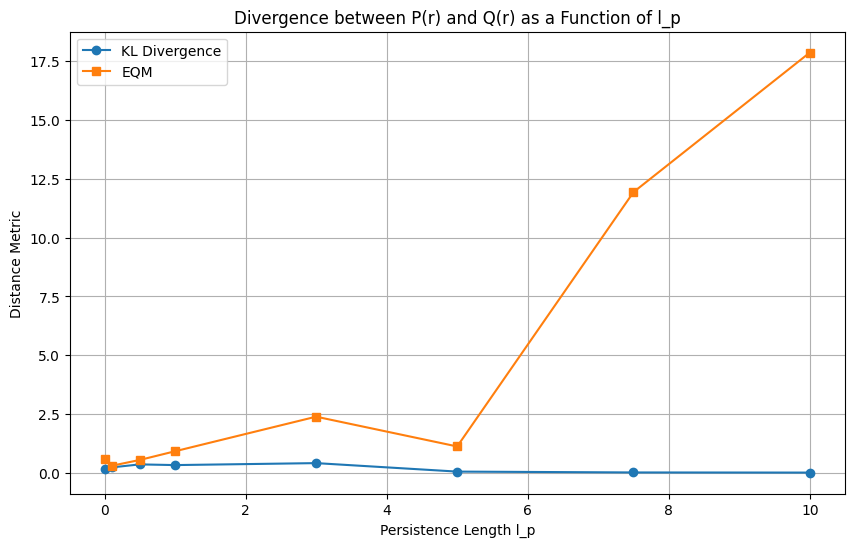

In [6]:
import importlib
import wlc_module
importlib.reload(wlc_module)
import wlc_module as wlc
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy  # Per la divergenza KL

# Parametri del modello
L = 1.0
N = 500
b = L / N
lp_values = [0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 7.5, 10.0]
num_simulations = 1000

# Esegui la simulazione per ottenere le distanze
distances3 = wlc.run_simulationQ(N, b, lp_values, num_simulations, L)

# Calcola le metriche KL e EQM per ogni valore di l_p
kl_distances, eqm_distances = wlc.run_analysis(distances3, lp_values, N, b)

# Plot delle distanze in funzione di l_p
plt.figure(figsize=(10, 6))
plt.plot(lp_values, kl_distances, 'o-', label='KL Divergence')
plt.plot(lp_values, eqm_distances, 's-', label='EQM')
plt.xlabel('Persistence Length l_p')
plt.ylabel('Distance Metric')
plt.title('Divergence between P(r) and Q(r) as a Function of l_p')
plt.legend()
plt.grid(True)
plt.show()